In [ ]:
# If you have installed dgl-cuXX package, please uninstall it first.
!pip install  dgl -f https://data.dgl.ai/wheels/cu116/repo.html
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/cu116/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 4.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 311.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# !nvidia-smi

In [ ]:
# Mount your google drive in google colab - added
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Insert, change the directory 
import sys
sys.path.insert(0,'/content/drive/MyDrive/graph-based-fraud-detection-main')
# %cd /content/drive/MyDrive/dgl_fraud_detection
%cd /content/drive/MyDrive/graph-based-fraud-detection-main

/content/drive/MyDrive/graph-based-fraud-detection-main


In [ ]:
import os
import sys
import glob

os.environ['DGLBACKEND'] = 'pytorch'

import torch as th
import dgl
import numpy as np

from gnn.estimator_fns import *
from gnn.graph_utils import *
from gnn.data import *
from gnn.utils import *
from gnn.pytorch_model import *
from train import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn

DLG version: 1.0.2+cu116


Load Yelp Fraud Dataset -https://docs.dgl.ai/generated/dgl.data.FraudDataset.html

In [ ]:
dataset = dgl.data.FraudDataset('yelp')
g = dataset[0]
n_classes = dataset.num_classes
features = g.ndata['feature']
labels = g.ndata['label']

Extracting file to /root/.dgl/yelp
Done saving data into cached files.


In [ ]:
g # bidirected graph

Graph(num_nodes={'review': 45954},
      num_edges={('review', 'net_rsr', 'review'): 6805486, ('review', 'net_rtr', 'review'): 1147232, ('review', 'net_rur', 'review'): 98630},
      metagraph=[('review', 'review', 'net_rsr'), ('review', 'review', 'net_rtr'), ('review', 'review', 'net_rur')])

In [ ]:
g.number_of_edges()

8051348

In [ ]:
g.ndata['feature'].shape

torch.Size([45954, 32])

In [ ]:
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

In [ ]:
train_mask

tensor([False,  True,  True,  ..., False,  True,  True])

Get Arguments

In [ ]:
args = parse_args()
print(args)

Namespace(training_dir='./data', model_dir='./model/2023_05_03_04_45_52', output_dir='./output', nodes='features.csv', target_ntype='TransactionID', edges='relation*', labels='tags.csv', new_accounts='test.csv', compute_metrics=True, threshold=0, num_gpus=0, optimizer='adam', lr=0.01, n_epochs=1000, n_hidden=32, n_layers=6, weight_decay=0.0005, dropout=0.2, embedding_size=360)


In [ ]:
# first setting n_epochs=500, n_layers=8, n_hidden=32
# second seeting n_epochs=1000, n_layers=6, n_hidden=32 
args.n_epochs = 200
args.n_hidden = 32
args.n_layers = 3
print(args)

Namespace(training_dir='./data', model_dir='./model/2023_04_27_23_43_44', output_dir='./output', nodes='features.csv', target_ntype='TransactionID', edges='relation*', labels='tags.csv', new_accounts='test.csv', compute_metrics=True, threshold=0, num_gpus=0, optimizer='adam', lr=0.01, n_epochs=1000, n_hidden=32, n_layers=3, weight_decay=0.0005, dropout=0.2, embedding_size=360)


In [ ]:
features

tensor([[0.0224, 0.0705, 0.4287,  ..., 0.5920, 0.1393, 0.4975],
        [0.0249, 1.0000, 1.0000,  ..., 0.5920, 0.1393, 0.4975],
        [0.0062, 0.0705, 0.4287,  ..., 0.5920, 0.1393, 0.4975],
        ...,
        [0.0091, 0.3500, 0.4287,  ..., 0.4826, 0.8010, 0.1642],
        [0.0062, 0.0705, 1.0000,  ..., 0.4428, 0.4478, 0.5871],
        [0.0032, 0.3500, 0.4287,  ..., 0.4428, 0.4478, 0.5871]])

In [ ]:
mean, stdev, features = normalize(features)

print('feature mean shape:{}, std shape:{}'.format(mean.shape, stdev.shape))

feature mean shape:torch.Size([32]), std shape:torch.Size([32])


In [ ]:
features

tensor([[-1.6035, -1.4759, -1.1635,  ...,  0.3962, -1.0901, -0.0316],
        [-1.5947,  1.7394,  0.8595,  ...,  0.3962, -1.0901, -0.0316],
        [-1.6594, -1.4759, -1.1635,  ...,  0.3962, -1.0901, -0.0316],
        ...,
        [-1.6493, -0.5090, -1.1635,  ...,  0.0575,  1.2891, -1.1550],
        [-1.6594, -1.4759,  0.8595,  ..., -0.0657,  0.0190,  0.2702],
        [-1.6697, -0.5090, -1.1635,  ..., -0.0657,  0.0190,  0.2702]])

# Training

In [ ]:
if args.num_gpus:
    cuda = True
    device = th.device('cuda:0')
else:
    cuda = False
    device = th.device('cpu')

print(device)

cpu


In [ ]:
# cuda = True
# device = th.device('cuda:0')
# print(device)

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

Initializing Model
Initialized Model
Starting Model training
Epoch 00000, Time(s) 1.2652, Loss 0.7342, F1 0.0000 
Epoch 00001, Time(s) 1.0687, Loss 0.4433, F1 0.0000 
Epoch 00002, Time(s) 0.8895, Loss 0.4544, F1 0.0000 
Epoch 00003, Time(s) 0.8093, Loss 0.4226, F1 0.0000 
Epoch 00004, Time(s) 0.7454, Loss 0.3811, F1 0.0000 
Epoch 00005, Time(s) 0.7058, Loss 0.3937, F1 0.0000 
Epoch 00006, Time(s) 0.6769, Loss 0.3988, F1 0.0000 
Epoch 00007, Time(s) 0.6540, Loss 0.3876, F1 0.0000 
Epoch 00008, Time(s) 0.6397, Loss 0.3754, F1 0.0000 
Epoch 00009, Time(s) 0.6347, Loss 0.3783, F1 0.0000 
Epoch 00010, Time(s) 0.6237, Loss 0.3854, F1 0.0000 
Epoch 00011, Time(s) 0.6234, Loss 0.3820, F1 0.0000 
Epoch 00012, Time(s) 0.6183, Loss 0.3763, F1 0.0000 
Epoch 00013, Time(s) 0.6109, Loss 0.3752, F1 0.0000 
Epoch 00014, Time(s) 0.6169, Loss 0.3775, F1 0.0000 
Epoch 00015, Time(s) 0.6263, Loss 0.3788, F1 0.0000 
Epoch 00016, Time(s) 0.6400, Loss 0.3769, F1 0.0000 
Epoch 00017, Time(s) 0.6553, Loss 0.37

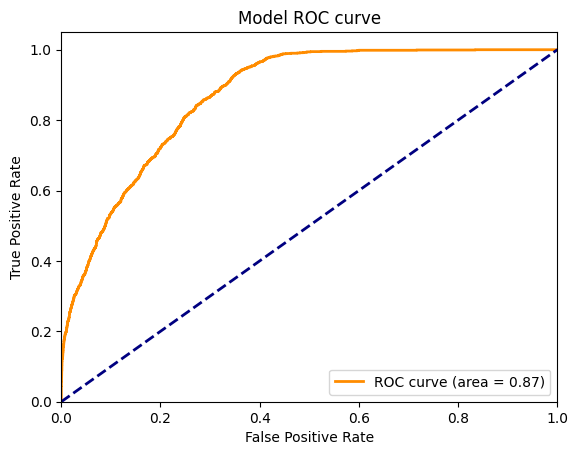

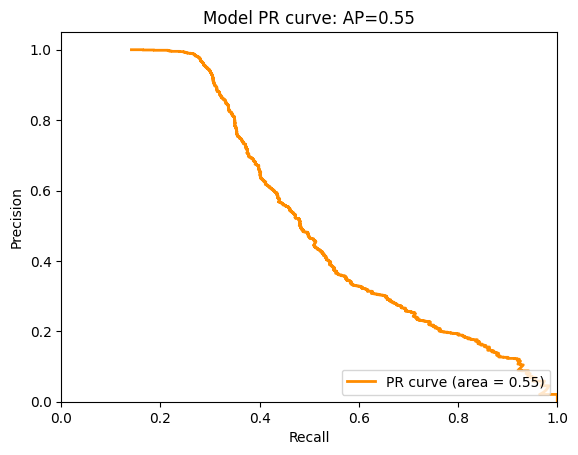

In [ ]:
print("Initializing Model")
in_feats = features.shape[1]
n_classes = 2

ntype_dict = {n_type: g.number_of_nodes(n_type) for n_type in g.ntypes}

model = get_model(ntype_dict, g.etypes, vars(args), in_feats, n_classes, device)
print("Initialized Model")

features = features.to(device)

labels = labels.long().to(device)
test_mask = test_mask.to(device)
g = g.to(device) #added

loss = th.nn.CrossEntropyLoss()

# print(model)
optim = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

print("Starting Model training")

# initial_record()
# Move the graph to the CUDA device
# g = g.to('cuda:0')
# Assign node feature "Wh_DeviceInfo<>target" to the graph
# g.ndata['Wh_DeviceInfo<>target'] = node_feature_cuda

model, class_preds, pred_proba = train_fg(model, optim, loss, features, labels, g, g,
                                            test_mask, device, args.n_epochs,
                                            args.threshold,  args.compute_metrics)
print("Finished Model training")

# print("Saving model") 

# if not os.path.exists(args.model_dir):
#     os.makedirs(args.model_dir)

# save_model(g, model, args.model_dir, id_to_node, mean, stdev)
# print("Model and metadata saved")